In [1]:
# Adi Agasi 
#Michal Yakobov

In [2]:
!pip install pymupdf
!pip install nltk
!pip install google-generativeai
!pip install spacy spacy-lookups-data spacytextblob
!python -m spacy download en_core_web_sm
!pip install sentence-transformers
!pip install google-generativeai

import pymupdf
import fitz  # PyMuPDF לקריאת PDF
# 📌 עיבוד שפה טבעית (NLP)
import spacy
import nltk
import google.generativeai as genai
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from spacytextblob.spacytextblob import SpacyTextBlob

# 📌 למידת מכונה (Machine Learning)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📌 אחזור מידע (Retrieval)
from sentence_transformers import SentenceTransformer, util
import numpy as np

# 📌 ניתוח ועיבוד נתונים
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 250.4 kB/s eta 0:00:50
     - ------------------------------------- 0.5/12.8 MB 250.4 kB/s eta 0:00:50
     - ------------------------------------- 0.5/12.8 MB 250.4 kB/s eta 0:00:50
     - ------------------------------------- 0.5/12.8 MB 250.4 kB/s eta 0:00:50
     - ------------------------------------- 0.5/12.8 MB 250.4 kB/s eta 0:00:50
     - -----------------

C:\Users\adiag\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# 📌 הורדת משאבים חסרים של NLTK
nltk.download('punkt')  # נדרש עבור עיבוד טקסט
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')  # נדרש עבור SentimentIntensityAnalyzer
nltk.download('wordnet')  # נדרש עבור WordNetLemmatizer
nltk.download('stopwords')  # נדרש עבור stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adiag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adiag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adiag\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adiag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adiag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:

# 1. טעינת מסמך קלט והמרתו לטקסט
class DocumentProcessor:
    """Handles loading and processing text from input files."""
    def load_pdf(self, file_path: str) -> str:
        """Load text from a PDF file and return extracted content."""
        text = ""
        doc = pymupdf.open(file_path)
        for page in doc:
            text += page.get_text("text") + "\n"
        return text

In [5]:

# 2. ניתוח מסמך - שליפת ישויות וניתוח סנטימנט

class FileAnalyzer:
    def __init__(self, ner_model_name="en_core_web_sm"):
        self.ner_model = spacy.load(ner_model_name)
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        self.sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        self.sentences = []
        self.sentence_embeddings = None
        self.intent_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    def extract_entities(self, text):
        """
        Extracts named entities from the text and categorizes them into places, people, organizations, dates, and numbers.
        """
        doc = self.ner_model(text)
        entities = {"places": [], "people": [], "organizations": [], "dates": [], "numbers": []}
        number_value = None  # Initialize to None in case no number is found

        for ent in doc.ents:
            if ent.label_ == "GPE":
                entities["places"].append(ent.text)
            elif ent.label_ == "PERSON":
                entities["people"].append(ent.text)
            elif ent.label_ == "ORG":
                entities["organizations"].append(ent.text)
            elif ent.label_ == "DATE":
                entities["dates"].append(ent.text)
            elif ent.label_ in ["CARDINAL", "QUANTITY"]:
                entities["numbers"].append(ent.text)
                try:
                    number_value = int(ent.text)
                except ValueError:
                    number_value = None  # Ignore invalid numbers

        return entities, number_value

    def analyze_sentiment(self, text):
        """
        Analyzes the sentiment of the given text and returns Positive, Negative, or Neutral.
        """
        sentiment = self.sentiment_analyzer.polarity_scores(text)
        return "Positive" if sentiment['compound'] > 0 else "Negative" if sentiment['compound'] < 0 else "Neutral"

    def preprocess_document(self, text, chunk_size):
        """
        Splits the document into chunks of a given size, ensuring better processing for semantic search.
        """
        sentences = nltk.sent_tokenize(text)
        chunks = []
        current_chunk = []
        current_length = 0

        for sentence in sentences:
            current_chunk.append(sentence)
            current_length += len(sentence)
            if current_length > chunk_size:
                chunks.append(" ".join(current_chunk))
                current_chunk = []
                current_length = 0

        if current_chunk:
            chunks.append(" ".join(current_chunk))

        return chunks

    def semantic_search(self, query, top_k=1):
        """
        Performs semantic search on the preprocessed document and returns the most relevant chunk.
        """
        if not self.sentences or self.sentence_embeddings is None:
            raise ValueError("Document not preprocessed. Call preprocess_document first.")

        query_embedding = self.sentence_model.encode([query], convert_to_tensor=True)
        similarities = util.cos_sim(query_embedding, self.sentence_embeddings)[0]
        best_idx = similarities.argmax().item()

        return self.sentences[best_idx]

    def search_chunks(self, chunks, query):
        """
        Searches for the best matching chunk from the document using semantic similarity.
        """
        chunk_embeddings = self.sentence_model.encode(chunks, convert_to_tensor=True)
        query_embedding = self.sentence_model.encode([query], convert_to_tensor=True)
        similarities = util.cos_sim(query_embedding, chunk_embeddings)[0]
        best_idx = similarities.argmax().item()

        return chunks[best_idx]


In [6]:

# 3. עיבוד השאלה - זיהוי ישויות, סיווג סנטימנט וזיהוי כוונה
class QuestionProcessor:
    def __init__(self, ner_model_name="en_core_web_sm", show_plots=False):
        self.ner_model = spacy.load(ner_model_name)
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        self.vectorizer = TfidfVectorizer()
        self.model = LogisticRegression()
        self.intent_labels = ["Fact", "Instruction", "Troubleshooting", "Opinion", "Definition"]
        self.show_plots = show_plots  # New flag to control showing plots
        self.trained = False  # Flag to track if model has been trained
        self.train_intent_model()

    def extract_question_words(self, question):
        """Identify question words like Who, What, When, Where, Why, How."""
        question_words = {"who", "what", "when", "where", "why", "how", "whose", "whom"}
        tokens = word_tokenize(question.lower())  # פירוק המילים בשאלה
        return [word for word in tokens if word in question_words]

    def train_intent_model(self):
        # Skip if already trained
        if self.trained:
            return

        sample_data = [
            {"question": "What are the main challenges of social media identified in the study?", "intent": "Fact"},
            {"question": "How can individuals protect their personal information on social media?", "intent": "Instruction"},
            {"question": "Why do social media platforms struggle with content moderation?", "intent": "Troubleshooting"},
            {"question": "What is the best approach to balance free speech and regulation on social media?", "intent": "Opinion"},
            {"question": "What is meant by 'me-too syndrome' in the context of social media?", "intent": "Definition"},
            {"question": "Which regions were included in the study on social media challenges in India?", "intent": "Fact"},
            {"question": "What steps can be taken to regulate harmful content on social media?", "intent": "Instruction"},
            {"question": "What causes slow internet speeds to impact social media usage in India?", "intent": "Troubleshooting"},
            {"question": "Should governments play a role in moderating social media content?", "intent": "Opinion"},
            {"question": "How does the study define the term 'social networking sites'?", "intent": "Definition"},
            {"question": "What impact does social media have on traditional journalism?", "intent": "Fact"},
            {"question": "How can social media companies combat misinformation?", "intent": "Instruction"},
            {"question": "Why do algorithms contribute to the spread of fake news?", "intent": "Troubleshooting"},
            {"question": "Are social media platforms more harmful or beneficial to democracy?", "intent": "Opinion"},
            {"question": "What is digital activism and how does it function?", "intent": "Definition"},
            {"question": "What are the most common ethical dilemmas in social media usage?", "intent": "Fact"},
            {"question": "How can users identify misinformation on social media?", "intent": "Instruction"},
            {"question": "Why do some posts go viral while others do not?", "intent": "Troubleshooting"},
            {"question": "Is it ethical for companies to collect user data from social media?", "intent": "Opinion"},
            {"question": "What does 'filter bubble' mean in relation to social media?", "intent": "Definition"},
            {"question": "What strategies do companies use to monetize social media?", "intent": "Fact"},
            {"question": "How can social media users improve their digital literacy?", "intent": "Instruction"},
            {"question": "Why do social media platforms face difficulties in removing hate speech?", "intent": "Troubleshooting"},
            {"question": "Should social media platforms be legally responsible for user-generated content?", "intent": "Opinion"},
            {"question": "What is the 'attention economy' and how does it influence social media?", "intent": "Definition"},
            {"question": "How has social media changed political campaigning?", "intent": "Fact"},
            {"question": "What are best practices for managing online privacy?", "intent": "Instruction"},
            {"question": "Why do echo chambers form on social media platforms?", "intent": "Troubleshooting"},
            {"question": "Do social media influencers have too much power over public opinion?", "intent": "Opinion"},
            {"question": "What is shadow banning and how does it work?", "intent": "Definition"},
            {"question": "What role does artificial intelligence play in content moderation?", "intent": "Fact"},
            {"question": "How can social media companies enhance user security?", "intent": "Instruction"},
            {"question": "Why do some online communities become toxic?", "intent": "Troubleshooting"},
            {"question": "Are social media addiction concerns exaggerated or justified?", "intent": "Opinion"},
            {"question": "What does 'clickbait' mean and how does it influence engagement?", "intent": "Definition"},
            {"question": "How does social media contribute to political polarization?", "intent": "Fact"},
            {"question": "What are effective ways to report online harassment?", "intent": "Instruction"},
            {"question": "Why do social media platforms sometimes fail to enforce their own rules?", "intent": "Troubleshooting"},
            {"question": "Is social media a reliable source of news?", "intent": "Opinion"},
            {"question": "What is astroturfing in the context of social media marketing?", "intent": "Definition"},
            {"question": "How do fake accounts impact social media discussions?", "intent": "Fact"},
            {"question": "What actions can users take to reduce social media addiction?", "intent": "Instruction"},
            {"question": "Why do social media platforms use targeted advertising?", "intent": "Troubleshooting"},
            {"question": "Should social media companies ban political ads?", "intent": "Opinion"},
            {"question": "What is a botnet and how is it used on social media?", "intent": "Definition"},
            {"question": "How do social media platforms track user activity?", "intent": "Fact"},
            {"question": "What are the steps to deactivate a social media account?", "intent": "Instruction"},
            {"question": "Why do some social media trends disappear quickly?", "intent": "Troubleshooting"},
            {"question": "Do social media platforms help or harm mental health?", "intent": "Opinion"},
            {"question": "What does 'cancel culture' mean and how does it affect social media users?", "intent": "Definition"},
            {"question": "What is the capital of France?", "intent": "Fact"},
            {"question": "How do I reset my password?", "intent": "Instruction"},
            {"question": "Why is my computer overheating?", "intent": "Troubleshooting"},
            {"question": "What is the best programming language?", "intent": "Opinion"},
            {"question": "What does API stand for?", "intent": "Definition"},
        ]
        df = pd.DataFrame(sample_data)
        X = df['question']
        y = df['intent']
        X_transformed = self.vectorizer.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
        self.model.fit(X_train, y_train)

        # Only show EDA if show_plots flag is True
        if self.show_plots:
            # Exploratory Data Analysis (EDA)
            print("Data Distribution:")
            print(df['intent'].value_counts())

            plt.figure(figsize=(10, 6))
            sns.countplot(x='intent', data=df)
            plt.title('Distribution of Intent Categories')
            plt.show()

            df['question_length'] = df['question'].apply(len)
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='intent', y='question_length', data=df)
            plt.title('Question Length by Intent Category')
            plt.show()

            # Model Evaluation
            y_pred = self.model.predict(X_test)
            print("Model Accuracy:", accuracy_score(y_test, y_pred))
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            print("\nConfusion Matrix:")
            conf_matrix = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=self.intent_labels, yticklabels=self.intent_labels)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
        else:
            # Simple text output for model training without plots
            print("Intent classification model trained successfully.")

        self.trained = True  # Mark model as trained

    def extract_entities(self, question):
        doc = self.ner_model(question)
        entities = {"places": [], "people": [], "organizations": [], "dates": [], "numbers": []}
        for ent in doc.ents:
            if ent.label_ == "GPE":
                entities["places"].append(ent.text)
            elif ent.label_ == "PERSON":
                entities["people"].append(ent.text)
            elif ent.label_ == "ORG":
                entities["organizations"].append(ent.text)
            elif ent.label_ == "DATE":
                entities["dates"].append(ent.text)
            elif ent.label_ in ["CARDINAL", "QUANTITY"]:
                entities["numbers"].append(ent.text)
               
        return entities


    def analyze_sentiment(self, question):
        sentiment = self.sentiment_analyzer.polarity_scores(question)
        return "Positive" if sentiment['compound'] > 0 else "Negative" if sentiment['compound'] < 0 else "Neutral"

    def classify_intent(self, question):
        question_vec = self.vectorizer.transform([question])
        return self.model.predict(question_vec)[0]

In [7]:

# 4. תקשורת עם המשתמש ומתן תשובה

class UserInteraction:
    @staticmethod
    def load_document(file_path=None):
        """Load document from specified path or use default."""
        if file_path is None:
            file_path = "/content/Artificial Intelligence and Its Applications.pdf"

        doc_processor = DocumentProcessor()
        try:
            document_text = doc_processor.load_pdf(file_path)

            if not document_text.strip():
                print("Error: No text found in the document.")
                return None, None  # מחזיר ערכים ריקים אם אין טקסט

            print(f"Document loaded successfully from: {file_path}")
            return doc_processor, document_text
        except Exception as e:
            print(f"Error loading document: {e}")
            return None, None

    def __init__(self, question_processor, file_analyzer=None):
        self.question_processor = question_processor
        self.file_analyzer = file_analyzer
        # Configure API key here inside the init method
        genai.configure(api_key="YOUR API")
        self.generation_model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp")


    def process_q(self, user_question: str) -> tuple:
        """Process user question and find relevant answer from document."""

        entities = self.question_processor.extract_entities(user_question)
        sentiment = self.question_processor.analyze_sentiment(user_question)
        intent = self.question_processor.classify_intent(user_question)
        question_words = self.question_processor.extract_question_words(user_question)

        # חיפוש תשובה במסמך
        relevant_sentences = []
        if self.file_analyzer:
            try:
                relevant_sentences = self.file_analyzer.semantic_search(user_question)
            except Exception as e:
                print(f"Error in retrieval process: {e}")

        if relevant_sentences:
            # שילוב המידע מהמסמך
            answer = "Based on the document, I found:\n\n"
            answer += f"- {relevant_sentences}\n"
            answer += "\nExpanding based on additional knowledge: "
            response = self.generation_model.generate_content(user_question + "\nExpand based on given information: " + relevant_sentences)
            answer += response.text
        else:
            # אם אין תשובה במסמך, יצירת תשובה גנרטיבית
            answer = "No direct answer was found in the document. However, here is a generated response:\n\n"
            response = self.generation_model.generate_content(user_question)
            answer += response.text

        return answer, intent, entities, sentiment, question_words

    def start_interaction(self):
        print("\nWelcome to the Document Question-Answering System!")
        print("You can ask questions about the loaded document.")
        print("Type 'exit' to end the session.\n")

        while True:
            try:
                user_question = input("\nWhat can I help you with? ")
                if user_question.lower() == 'exit':
                    print("Goodbye!")
                    break
                if not user_question.strip():
                    print("Please enter a valid question.")
                    continue

                answer, question_intent, question_entities, question_polarity, question_words = self.process_q(user_question)

                print("\nAnalysis Results:")
                print("-" * 50)
                print(f"Q: {user_question}")
                print(f"Question Intent: {question_intent}")
                print(f"Question Entities: {question_entities}")
                print(f"Question Words: {question_words}")
                print(f"Question Polarity: {question_polarity}")
                print("-" * 50)
                print("Answer:", answer)
            except KeyboardInterrupt:
                print("\nSession interrupted. Goodbye!")
                break
            except Exception as e:
                print(f"An error occurred: {e}")
                print("Let's try again with a different question.")


Starting Document QA System...
Document loaded successfully from: C:\Users\adiag\OneDrive\Desktop\P_211544713_322582099\Artificial Intelligence and Its Applications.pdf
Initializing NLP modules...
Training intent classification model...
Data Distribution:
intent
Fact               11
Instruction        11
Troubleshooting    11
Opinion            11
Definition         11
Name: count, dtype: int64


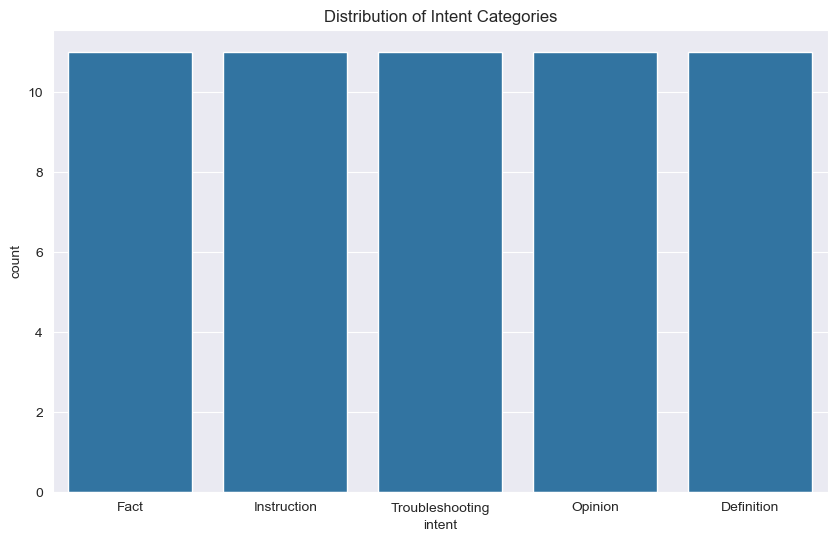

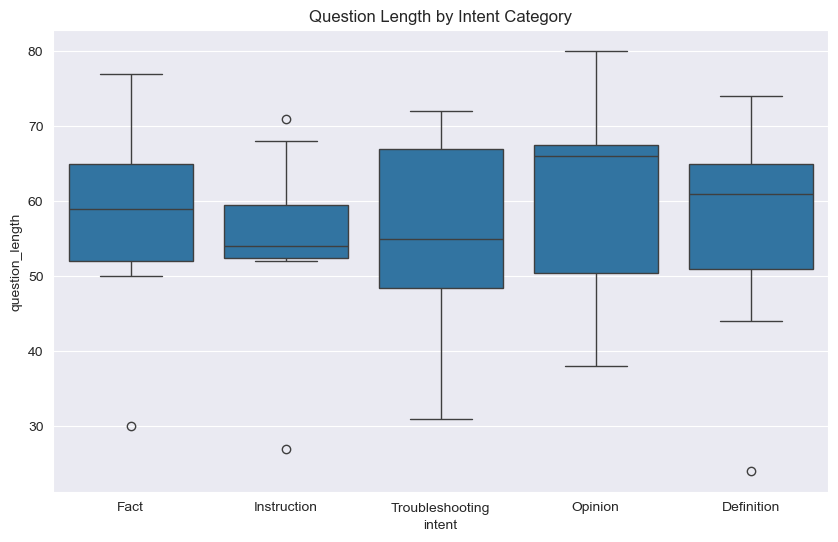

Model Accuracy: 0.5454545454545454

Classification Report:
                 precision    recall  f1-score   support

     Definition       1.00      0.50      0.67         2
           Fact       0.25      1.00      0.40         1
    Instruction       1.00      0.67      0.80         3
        Opinion       0.33      0.50      0.40         2
Troubleshooting       1.00      0.33      0.50         3

       accuracy                           0.55        11
      macro avg       0.72      0.60      0.55        11
   weighted avg       0.81      0.55      0.58        11


Confusion Matrix:


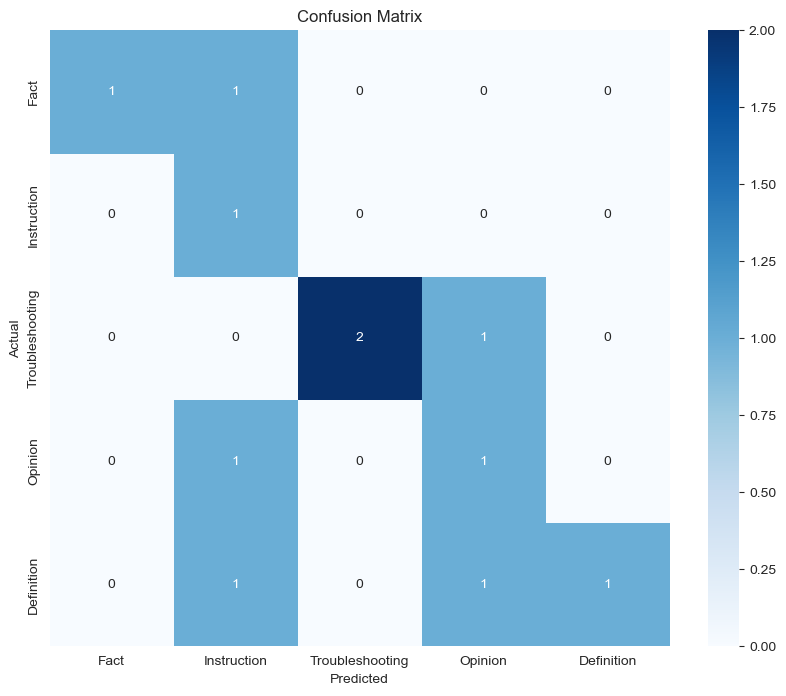

Ready for questions!

Welcome to the Document Question-Answering System!
You can ask questions about the loaded document.
Type 'exit' to end the session.


Analysis Results:
--------------------------------------------------
Q: hhh
Question Intent: Fact
Question Entities: {'places': [], 'people': [], 'organizations': [], 'dates': [], 'numbers': []}
Question Words: []
Question Polarity: Neutral
--------------------------------------------------
Answer: Based on the document, I found:

- 4. The Future of AI 
The future of AI holds great promise, with emerging trends shaping the technology landscape. Key developments include: 
• 
Explainable AI (XAI) – Ensuring AI models are transparent and understandable. • 
AI Ethics and Regulation – Governments and organizations are working on guidelines 
to promote responsible AI.

Expanding based on additional knowledge: Okay, here's an expansion of the provided information on "The Future of AI," incorporating more detail and potential avenues for ex

In [8]:

# Main execution block
def main():
    print("Starting Document QA System...")

    # Use a specific file path - hardcoded for reliability
    file_path = r"C:\Users\adiag\OneDrive\Desktop\P_211544713_322582099\Artificial Intelligence and Its Applications.pdf"
    file_path2 = r"C:\Users\adiag\OneDrive\Desktop\P_211544713_322582099\Social_Media_Challenges_and_Prospects.pdf"
    # Load document
    doc_processor, document_text = UserInteraction.load_document(file_path)

    if document_text:  # Continue only if document loaded successfully
        print("Initializing NLP modules...")
        # Initialize file analyzer with semantic search capabilities
        file_analyzer = FileAnalyzer()
        # Preprocessing document for semantic search
        chunks = file_analyzer.preprocess_document(document_text, chunk_size=300)
        file_analyzer.sentences = chunks
        file_analyzer.sentence_embeddings = file_analyzer.sentence_model.encode(chunks, convert_to_tensor=True)

        print("Training intent classification model...")
        # Only show graphs in initial training if desired
        question_processor = QuestionProcessor(show_plots=True)  

        print("Ready for questions!")
        ui = UserInteraction(question_processor, file_analyzer)
        ui.start_interaction()
    else:
        print("Could not proceed without a valid document. Please check the file path and try again.")

if __name__ == "__main__":
    main()